In [91]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
import csv

plt.style.use('ggplot')

In [92]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 50

# 学習の繰り返し回数
n_epoch = 20

# 中間層の数
n_units = 4


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/misyo/data_standardized"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:4])
                target_set.append(line[4])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 1200
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [93]:
# 多層パーセプトロンモデルの設定
# 入力 3次元、出力 2次元
model = FunctionSet(l1=F.Linear(3, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.0, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.0, train=train)
        y = model.l3(h2)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)



In [94]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = []
l2_W = []
l3_W = []



epoch 1
train mean loss=0.541864526769, accuracy=0.719999991357
test  mean loss=0.476221211197, accuracy=0.796705422013
epoch 2
train mean loss=0.461994235714, accuracy=0.791666666667
test  mean loss=0.49730701271, accuracy=0.787403098373
epoch 3
train mean loss=0.4591332376, accuracy=0.795833326876
test  mean loss=0.486471301825, accuracy=0.788178291432
epoch 4
train mean loss=0.458194406082, accuracy=0.793333326777
test  mean loss=0.473728801391, accuracy=0.793604652087
epoch 5
train mean loss=0.455818874141, accuracy=0.796666661898
test  mean loss=0.493461777304, accuracy=0.783527128456
epoch 6
train mean loss=0.454327060531, accuracy=0.799999989569
test  mean loss=0.476086531268, accuracy=0.79050387523
epoch 7
train mean loss=0.455015740047, accuracy=0.794166661799
test  mean loss=0.490851231324, accuracy=0.781007748704
epoch 8
train mean loss=0.452585216612, accuracy=0.798333329459
test  mean loss=0.474825348965, accuracy=0.790503872919
epoch 9
train mean loss=0.45326373602, accur

[]

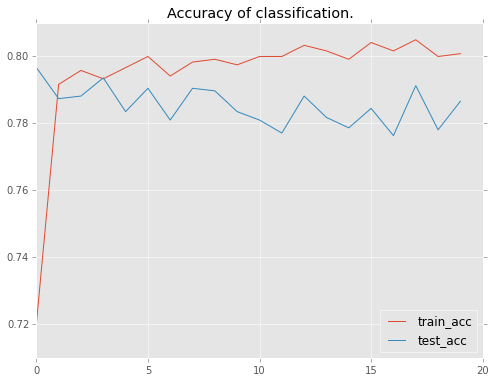

In [95]:
# Learning loop
for epoch in xrange(1, n_epoch+1):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch)
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)

        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[i:i+batchsize]
                y_batch = y_test[i:i+batchsize]

                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch, train=False)

                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append(sum_loss / N_test)
        test_acc.append(sum_accuracy / N_test)


        # 学習したパラメーターを保存
        l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        l3_W.append(model.l3.W)

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()